# Basic Cell Clustering Using mCG-5Kb Bins

## Content

Here we go through the basic steps to perform cell clustering using genome non-overlapping 5Kb bins
as features. We start from hypo-methylation probability data stored in MCDS (quantified by the hypo- or hyper-methylation score option, see `allcools generate-dataset`). This notebook can be used to quickly evaluate cell-type composition in a single-cell methylome dataset (e.g., the dataset from a single experiment).
Comparing with the 100Kb bins clustering process, this clustering process is more suitable for samples with low mCH fraction (many non-brain tissues) and narrow methylation diversity (so smaller feature works better).

### Dataset used in this notebook
- Adult (age P56) male mouse brain pituitary (PIT) snmC-seq2 data from {cite:p}`RufZamojski2021`.

## Input
- MCDS with chrom5k hypo-score matrix
- Cell metadata

## Output
- Cell-by-5kb-bin AnnData (sparse matrix) with embedding coordinates and cluster labels.

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from ALLCools.mcds import MCDS
from ALLCools.clustering import tsne, significant_pc_test, filter_regions, lsi, binarize_matrix
from ALLCools.plot import *

## Parameters

In [2]:
metadata_path = '../../data/PIT/PIT.CellMetadata.csv.gz'
mcds_path = '../../data/PIT/RufZamojski2021NC.mcds'

# Basic filtering parameters
mapping_rate_cutoff = 0.5
mapping_rate_col_name = 'MappingRate'  # Name may change
final_reads_cutoff = 500000
final_reads_col_name = 'FinalmCReads'  # Name may change
mccc_cutoff = 0.03
mccc_col_name = 'mCCCFrac'  # Name may change
mch_cutoff = 0.2
mch_col_name = 'mCHFrac'  # Name may change
mcg_cutoff = 0.5
mcg_col_name = 'mCGFrac'  # Name may change

# PC cutoff
pc_cutoff = 0.1

# KNN
knn = -1  # -1 means auto determine

# Leiden
resolution = 1

## Load Cell Metadata

In [3]:
metadata = pd.read_csv(metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 2756 cells


CellInputReadPairs  MappingRate  FinalmCReads  \
index                                                                   
PIT_P1-PIT_P2-A1-AD001           1858622.0     0.685139     1612023.0   
PIT_P1-PIT_P2-A1-AD004           1599190.0     0.686342     1367004.0   
PIT_P1-PIT_P2-A1-AD006           1932242.0     0.669654     1580990.0   
PIT_P1-PIT_P2-A1-AD007           1588505.0     0.664612     1292770.0   
PIT_P1-PIT_P2-A1-AD010           1738409.0     0.703835     1539676.0   

                        mCCCFrac   mCGFrac   mCHFrac   Plate  Col384  Row384  \
index                                                                          
PIT_P1-PIT_P2-A1-AD001  0.003644  0.679811  0.005782  PIT_P1       0       0   
PIT_P1-PIT_P2-A1-AD004  0.004046  0.746012  0.008154  PIT_P1       1       0   
PIT_P1-PIT_P2-A1-AD006  0.003958  0.683584  0.005689  PIT_P1       1       1   
PIT_P1-PIT_P2-A1-AD007  0.003622  0.735217  0.005460  PIT_P2       0       0   
PIT_P1-PIT_P2-A1-AD010  0.003769  0.744640  0.006679  PIT_P2       1       0   

                        CellTypeAnno  
index                                 
PIT_P1-PIT_P2-A1-AD001       Outlier  
PIT_P1-PIT_P2-A1-AD004  Gonadotropes  
PIT_P1-PIT_P2-A1-AD006  Somatotropes  
PIT_P1-PIT_P2-A1-AD007        Rbpms+  
PIT_P1-PIT_P2-A1-AD010        Rbpms+

## Filter Cells

In [4]:
judge = (metadata[mapping_rate_col_name] > mapping_rate_cutoff) & \
        (metadata[final_reads_col_name] > final_reads_cutoff) & \
        (metadata[mccc_col_name] < mccc_cutoff) & \
        (metadata[mch_col_name] < mch_cutoff) & \
        (metadata[mcg_col_name] > mcg_cutoff)

metadata = metadata[judge].copy()
# cell metadata for this example is filtered already
print(f'{metadata.shape[0]} cells passed filtering')

2756 cells passed filtering


## Load hypo-methylation score matrix from MCDS

In [5]:
mcds = MCDS.open(mcds_path, var_dim='chrom5k')

In [6]:
mcds.add_cell_metadata(metadata)

In [7]:
mcds = mcds.remove_black_list_region(black_list_path='../../data/genome/mm10-blacklist.v2.bed.gz')

49908 chrom5k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [8]:
mcad = mcds.get_score_adata(mc_type='CGN', quant_type='hypo-score')

In [9]:
mcad

AnnData object with n_obs × n_vars = 2756 × 495206
    obs: 'CellInputReadPairs', 'MappingRate', 'FinalmCReads', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Plate', 'Col384', 'Row384', 'CellTypeAnno'
    var: 'chrom', 'end', 'start'

## Binarize

In [10]:
binarize_matrix(mcad, cutoff=0.95)

## Filter Features

In [11]:
filter_regions(mcad)

Filter out 206777 regions with # of non-zero cells <= 13


array([False, False, False, ...,  True,  True,  True])

In [12]:
mcad

AnnData object with n_obs × n_vars = 2756 × 288429
    obs: 'CellInputReadPairs', 'MappingRate', 'FinalmCReads', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Plate', 'Col384', 'Row384', 'CellTypeAnno'
    var: 'chrom', 'end', 'start'

## TF-IDF Transform and Dimension Reduction

In [13]:
# by default we save the results in adata.obsm['X_pca'] which is the scanpy defaults in many following functions
# But this matrix is not calculated by PCA
lsi(mcad, algorithm='arpack', obsm='X_pca')

TruncatedSVD(algorithm='arpack', n_components=100, random_state=0)

In [14]:
# choose significant components
significant_pc_test(mcad, p_cutoff=pc_cutoff, update=True)

13 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (2756, 100) to (2756, 13)


13

## Clustering

### Calculate Nearest Neighbors

In [15]:
if knn == -1:
    knn = max(15, int(np.log2(mcad.shape[0])*2))
sc.pp.neighbors(mcad, n_neighbors=knn)

## Leiden Clustering

In [16]:
sc.tl.leiden(mcad, resolution=resolution)

## Manifold learning

### tSNE

In [17]:
tsne(mcad,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

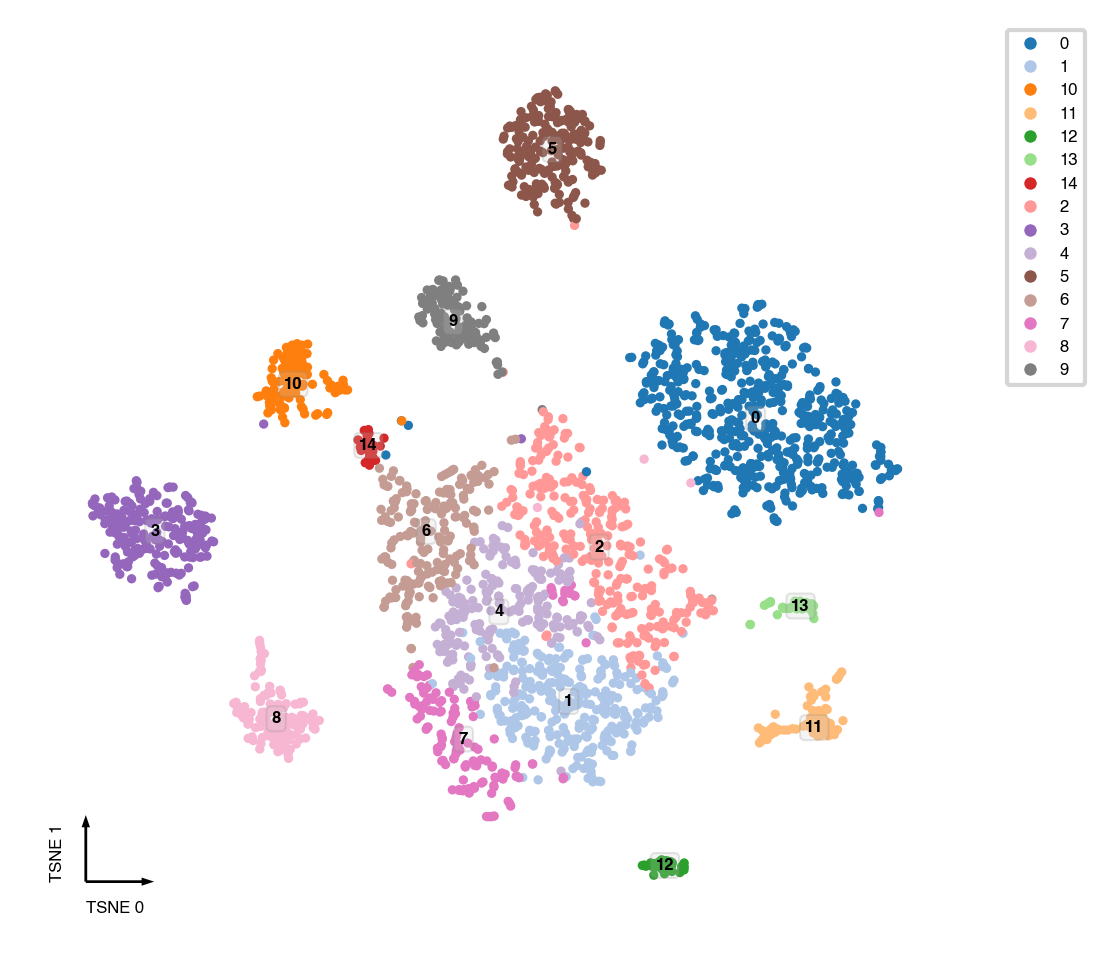

In [18]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
_ = categorical_scatter(data=mcad,
                        ax=ax,
                        coord_base='tsne',
                        hue='leiden',
                        text_anno='leiden',
                        show_legend=True)

### UMAP

In [19]:
sc.tl.umap(mcad)

In [20]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
_ = categorical_scatter(data=mcad,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        text_anno='leiden',
                        show_legend=True)

### Interactive plot

In [26]:
interactive_scatter(data=mcad, hue='leiden', coord_base='umap')

## Save results

In [ ]:
mcad.write_h5ad('PIT.mCG-5K-clustering.h5ad')
mcad

In [ ]:
mcad.obs.to_csv('PIT.ClusteringResults.csv.gz')
mcad.obs.head()

## Sanity test

This test dataset come from {cite:p}`RufZamojski2021`, so we already annotated the cell types. For new datasets, see following notebooks about identifying cluster markers and annotate clusters

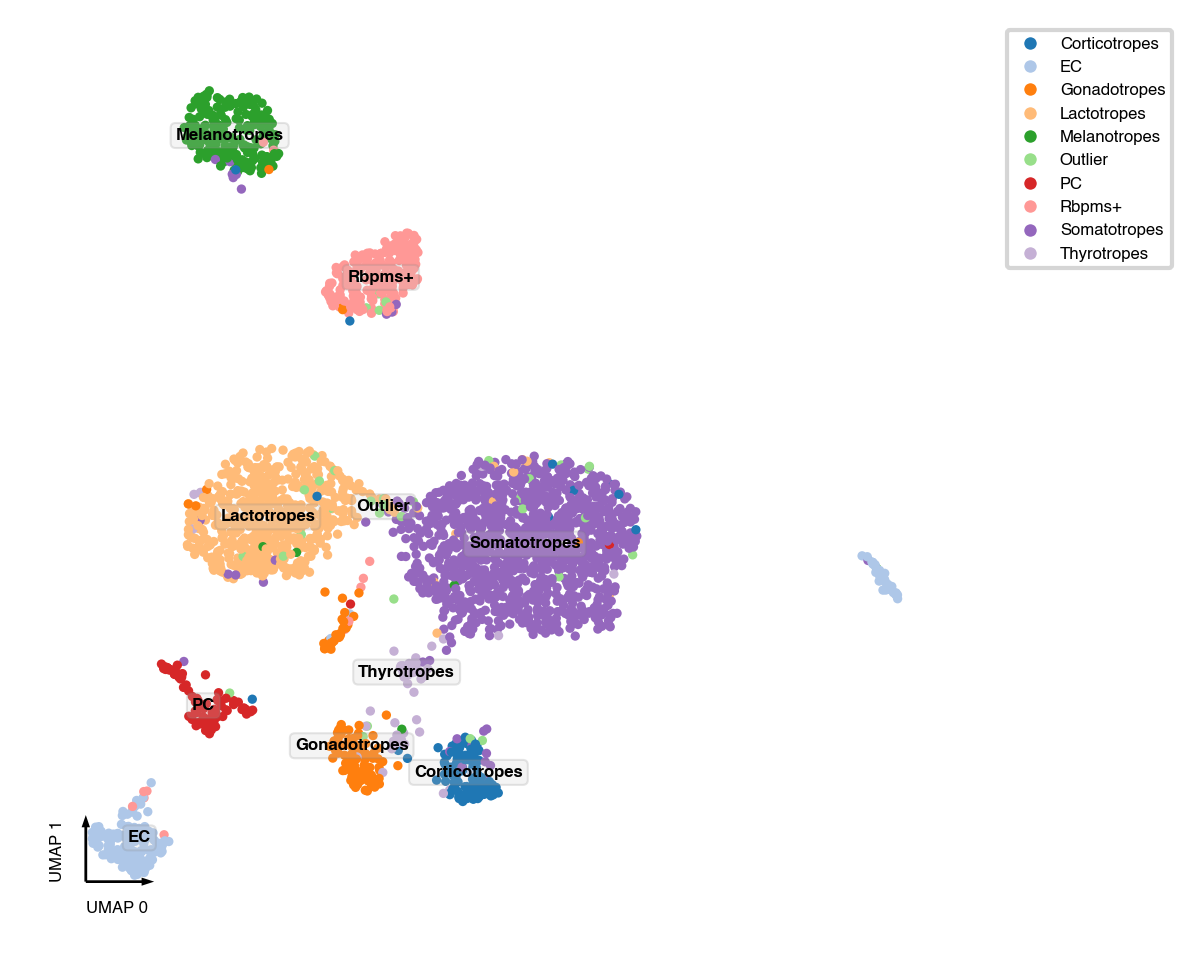

In [27]:
if 'CellTypeAnno' in mcad.obs:
    mcad.obs['CellTypeAnno'] = mcad.obs['CellTypeAnno'].fillna('Outlier')
    
    fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
    _ = categorical_scatter(data=mcad,
                            ax=ax,
                            coord_base='umap',
                            hue='CellTypeAnno',
                            text_anno='CellTypeAnno',
                            palette='tab20',
                            show_legend=True)